In [1]:
import random
from IPython.display import display
from PIL import Image

import cv2
import torch
import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from utils.directory import fetch_rgb_path, fetch_segformer_path
from scripts.compute_iou import create_line_mesh_from_center_size, select_inlier_pcd
from utils.directory import fetch_xyzrgb_pcd_path, fetch_xyzrgb_mask_path


def paint_color_dbscan(pcd, pcd_th_ratio=0.05):
    labels = np.array(pcd.cluster_dbscan(eps=0.2, min_points=10, print_progress=False))

    max_label = labels.max()
    print(f"point cloud has {max_label + 1} clusters")
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])

    num_points = labels.shape[0]
    num_count_threshold = int(pcd_th_ratio * num_points)
    inlier_labels = []
    for l in range(np.min(labels), np.max(labels) + 1):
        count = np.sum(labels == l)
        if count > num_count_threshold:
            inlier_labels.append(l)
    indices = np.where(np.isin(labels, inlier_labels))[0]
    # return pcd
    return pcd.select_by_index(indices)


def visualize_pcd_and_bbox(pcd, bbox, use_cluster):
    obj_list = []
    pcd_ = o3d.geometry.PointCloud()
    pcd_.points = o3d.utility.Vector3dVector(pcd[..., :3])
    if use_cluster:
        pcd_ = paint_color_dbscan(pcd_)
    # pcd_ = select_inlier_pcd(pcd_, 0.1)
    obj_list.append(pcd_)
    lm = create_line_mesh_from_center_size(np.array(bbox))
    obj_list += lm.cylinder_segments
    o3d.visualization.draw_geometries(obj_list)


def o3d_pcd_from_numpy(pcd_numpy):
    if len(pcd_numpy.shape) > 2:
        pcd_numpy = np.reshape(pcd_numpy[..., :3], (-1, 3))
    pcd_o3d = o3d.geometry.PointCloud()
    pcd_o3d.points = o3d.utility.Vector3dVector(pcd_numpy[..., :3])
    return pcd_o3d


def visualize_pcd_and_mask(pcd, mask = None):
    obj_list = []

    if mask is not None:
        obj_list.append(o3d_pcd_from_numpy(pcd))
        pcd2 = o3d_pcd_from_numpy(pcd[mask, :3])
        pcd2.translate([0, 0, 1])
        obj_list.append(pcd2)
        print(pcd.shape[0] * pcd.shape[1])
        print(pcd[mask, :].shape[0])
        npcd = pcd[~mask, :]
        print(npcd[:10, :])
    else:
        obj_list.append(o3d_pcd_from_numpy(pcd))
    # lm = create_line_mesh_from_center_size(np.array(bbox))
    # obj_list += lm.cylinder_segments
    o3d.visualization.draw_geometries(obj_list)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
pcd_old = torch.load('/home/junha/data/sunrefer/pcd/pcd_1000_old/pcd_train.pt')
pcd_new = torch.load('/home/junha/data/sunrefer/pcd/pcd_1000_new/pcd_train.pt')

In [3]:
image_id = '000001'
xyz = np.load(str(fetch_xyzrgb_pcd_path(image_id)))
mask = np.load(str(fetch_xyzrgb_mask_path(image_id)))

In [5]:
# pcd_old = torch.load('/home/junha/data/sunrefer/pcd/pcd_1000_old/pcd_train.pt')
# pcd_new = torch.load('/home/junha/data/sunrefer/pcd/pcd_1000_new/pcd_train.pt')
pcd_seg = torch.load('/home/junha/data/sunrefer/pcd/pcd_1000_seg/pcd_train.pt')

In [6]:
print(len(pcd_old), len(pcd_new), len(pcd_seg))

30537 19416 29897


In [7]:
cls_name, pcd, bbox = pcd_seg[10000]
visualize_pcd_and_bbox(pcd, bbox, True)
visualize_pcd_and_bbox(pcd, bbox, False)

point cloud has 7 clusters


In [8]:
CL = [
    [-1, -1, -1],
    [1, -1, -1],
    [-1, 1, -1],
    [1, 1, -1],
    [-1, -1, 1],
    [1, -1, 1],
    [-1, 1, 1],
    [1, 1, 1]]


def center_size_from_bbox_dict(bbox_dict):
    centroid = np.array(bbox_dict['centroid'])[0]  # (3, )
    basis = np.array(bbox_dict['basis'])  # (3, 3)
    coeffs = np.array(bbox_dict['coeffs'])[0]  # (3, )
    ux = basis[0] * coeffs[0]
    uy = basis[1] * coeffs[1]
    uz = basis[2] * coeffs[2]
    verts = np.array([sx * ux + sy * uy + sz * uz for sx, sy, sz in CL])
    x_min = np.min(verts[:, 0], axis=0)
    x_max = np.max(verts[:, 0], axis=0)
    y_min = np.min(verts[:, 1], axis=0)
    y_max = np.max(verts[:, 1], axis=0)
    z_min = np.min(verts[:, 2], axis=0)
    z_max = np.max(verts[:, 2], axis=0)
    cx = (x_min + x_max) / 2
    cy = (y_min + y_max) / 2
    cz = (z_min + z_max) / 2
    sx = x_max - x_min
    sy = y_max - y_min
    sz = z_max - z_min
    cs = np.array([cx, cy, cz, sx, sy, sz])
    cs[:3] += centroid
    # return cs
    new_cs = np.array([cs[0], cs[2], -cs[1], cs[3], cs[5], cs[4]])
    return new_cs


def fetch_pcd_from_center_size(flat_pcd, cs):
    center, size = cs[:3], cs[3:]
    p1 = center - 0.5 * size
    p2 = center + 0.5 * size

    mx = (p1[0] <= flat_pcd[..., 0]) & (flat_pcd[..., 0] <= p2[0])
    my = (p1[1] <= flat_pcd[..., 1]) & (flat_pcd[..., 1] <= p2[1])
    mz = (p1[2] <= flat_pcd[..., 2]) & (flat_pcd[..., 2] <= p2[2])
    return flat_pcd[mx & my & mz, :]


def visualize_pcd_and_bbox_list(image, pcd, seg_mask, bbox_3d_list, bbox_2d_list):
    obj_list = []
    height, width = image.shape[0], image.shape[1]
    canvas = np.zeros_like(image)
    print(canvas.shape)
    colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
              for _ in range(len(bbox_3d_list))]
    for bbox, color in list(zip(bbox_3d_list, colors))[::-1]:
        inliers = fetch_pcd_from_center_size(pcd, bbox)
        x = (inliers[..., 3] * width).astype(dtype=np.int64)
        y = (inliers[..., 4] * height).astype(dtype=np.int64)
        counters = [0 for _ in range(len(bbox_2d_list))]
        for xx, yy in zip(x, y):
            if 0 <= xx < width and 0 <= yy < height:
                canvas[yy, xx, :] = color
                for j, (x1, y1, x2, y2) in enumerate(bbox_2d_list):
                    if x1 <= xx < x2 and y1 <= yy < y2:
                        counters[j] += 1
        print(bbox, counters)
        pcd_o3d = o3d.geometry.PointCloud()
        pcd_o3d.points = o3d.utility.Vector3dVector(inliers[..., :3])
        obj_list.append(pcd_o3d)
        lm = create_line_mesh_from_center_size(np.array(bbox))
        obj_list += lm.cylinder_segments

    if seg_mask is not None:
        canvas[seg_mask, :] = 0

    for x1, y1, x2, y2 in bbox_2d_list:
        cv2.rectangle(canvas, (x1, y1), (x2, y2), (255, 0, 0))

    o3d.visualization.draw_geometries(obj_list)

    display(Image.fromarray(canvas))
    # fig = plt.figure(figsize=(16, 10))
    # plt.imshow(canvas)
    # plt.show()

In [45]:
obj_info_by_image_id = torch.load('/home/junha/data/sunrefer/meta.pt')

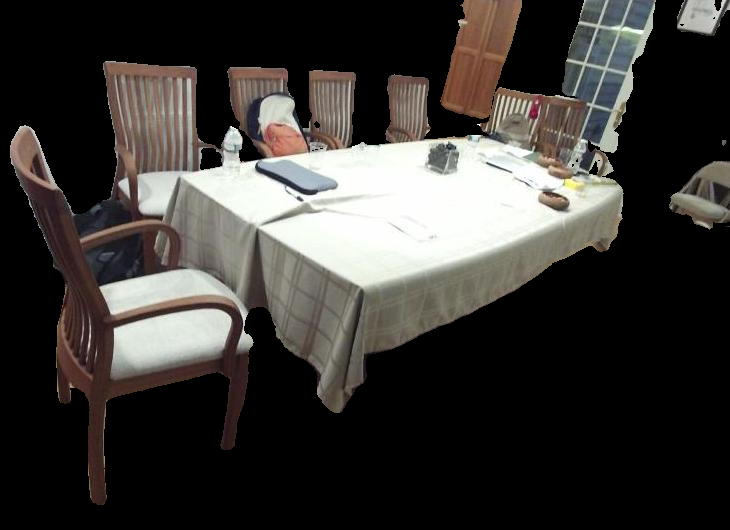

In [171]:
rgb = cv2.cvtColor(cv2.imread(str(fetch_rgb_path(image_id)), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
# rgb = cv2.imread(str(fetch_rgb_path(image_id)), cv2.IMREAD_COLOR)
seg_out = np.load(str(fetch_segformer_path(image_id)))
seg_mask = np.zeros(seg_out.shape, dtype=bool)
for label in [0, 3, 5]:
    seg_mask[seg_out == label] = True
rgb[seg_mask, :] = 0

rgb = Image.fromarray(rgb)
display(rgb)

obj_3d
['dining_table', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'table']
obj_2d
['dining_table', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'chair', 'door']
(530, 730, 3)
[ 0.315 -0.75  -3.27   4.87   1.67   5.36 ] [95366, 86463, 17914, 10129, 4446, 2283, 2596, 3438, 872, 13681]
[ 1.76  -0.965 -4.525  0.83   0.94   0.83 ] [604, 0, 0, 0, 0, 0, 595, 1872, 0, 1879]
[ 1.26  -0.95  -4.375  0.59   0.95   0.63 ] [491, 0, 0, 0, 0, 0, 2329, 916, 0, 973]
[ 0.38728684 -0.99370783 -4.09432478  0.67776553  0.92727273  0.67955865] [79, 0, 0, 0, 0, 1911, 0, 0, 0, 0]
[-0.11358065 -1.01188965 -3.57530338  0.63526454  0.96363636  0.63378584] [225, 0, 0, 1794, 3218, 20, 0, 0, 0, 0]
[-0.50479237 -1.01188965 -3.10909091  0.63337049  0.96363636  0.63636364] [1372, 353, 0, 6118, 340, 0, 0, 0, 0, 0]
[-0.89570146 -1.02552601 -2.58181818  0.62626687  0.97272727  0.61818182] [734, 5445, 10474, 33, 0, 0, 0, 0, 0, 0]
[-0.52776656 -1.03461692 -1.42727273  0.77272727  1.063

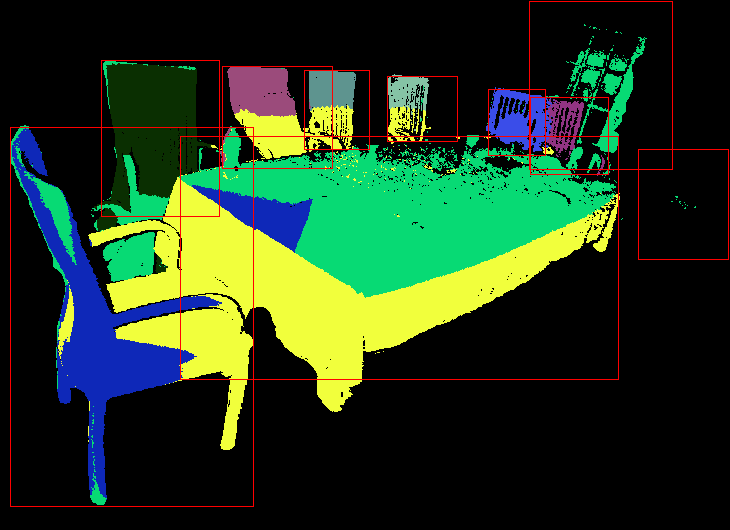

In [174]:
image_id = '005051'

rgb = cv2.imread(str(fetch_rgb_path(image_id)), cv2.IMREAD_COLOR)
xyz = np.reshape(np.load(str(fetch_xyzrgb_pcd_path(image_id))), (-1, 8))

seg_out = np.load(str(fetch_segformer_path(image_id)))
seg_mask = np.zeros(seg_out.shape, dtype=bool)
for label in [0, 3, 5]:
    seg_mask[seg_out == label] = True

bbox_3d_list = [center_size_from_bbox_dict(obj_3d) for obj_3d in obj_info_by_image_id[image_id]['obj_3d']]
bbox_2d_list = [(obj['bbox_2d'][0], obj['bbox_2d'][1], obj['bbox_2d'][0] + obj['bbox_2d'][2], obj['bbox_2d'][1] + obj['bbox_2d'][3])
                for obj in obj_info_by_image_id[image_id]['obj_2d']]
print('obj_3d')
print([obj['class_name'] for obj in obj_info_by_image_id[image_id]['obj_3d']])
print('obj_2d')
print([obj['class_name'] for obj in obj_info_by_image_id[image_id]['obj_2d']])

visualize_pcd_and_bbox_list(rgb, xyz, seg_mask, bbox_3d_list, bbox_2d_list)